## Evaluating point forecast accuracy
***

## Training and test sets

It is important to evaluate forecast accuracy using genuine forecasts. Consequently, the size of the residuals is not a reliable indication of how large true forecast errors are likely to be. The accuracy of forecasts can only be determined by considering how well a model performs on new data that were not used when fitting the model.

When choosing models, it is common practice to separate the available data into two portions, training and test data, where the training data is used to estimate any parameters of a forecasting method and the test data is used to evaluate its accuracy. Because the test data is not used in determining the forecasts, it should provide a reliable indication of how well the model is likely to forecast on new data.

![](Assets/traintest-1.png)

The size of the test set is typically about 20% of the total sample, although this value depends on how long the sample is and how far ahead you want to forecast. The test set should ideally be at least as large as the maximum forecast horizon required. The following points should be noted.

+ A model which fits the training data well will not necessarily forecast well.
+ A perfect fit can always be obtained by using a model with enough parameters.
+ Over-fitting a model to data is just as bad as failing to identify a systematic pattern in the data.

Some references describe the test set as the “hold-out set” because these data are “held out” of the data used for fitting. Other references call the training set the “in-sample data” and the test set the “out-of-sample data”. We prefer to use “training data” and “test data” in this book.

## Functions to subset a time series

*To filter DataFrames with Boolean Masks we use the index operator and pass a comparison for a specific column*, such as we need when creating training and test sets. When splitting data into evaluation sets, filtering the index of the data is particularly useful. For example:


In [ ]:
# Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np
import scipy
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage
from statsforecast.models import Naive
from statsforecast.models import SeasonalNaive
from statsforecast.models import RandomWalkWithDrift
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a dataframe from a csv file:
aus_production = pd.read_csv("Assets/aus-production.csv", sep=";")

In [3]:
# Filter the year of interest:
aus_production_mask = aus_production["Quarter"] >= "1995"
filtered_aus_production = aus_production[aus_production_mask]

extracts all data from 1995 onward. Equivalently,

In [4]:
# Filter the year of interest:
aus_production_mask = aus_production["Quarter"] >= "1995 Q1"
filtered_aus_production = aus_production[aus_production_mask]

can be used.

Another useful function is `iloc()`, which allows the use of indices to choose a subset from each group. For example,

In [5]:
last_20 = aus_production.iloc[-20:]

extracts the last 20 observations (5 years).

## Forecast errors

A forecast “error” is the difference between an observed value and its forecast. Here “error” does not mean a mistake, it means the unpredictable part of an observation. It can be written as

\begin{gather*} 
\hat{e}_{T+h} = y_{T+h} - \hat{y}_{T+h|T}
\end{gather*}

where the training data is given by {$y_{1},…,y_{T}$} and the test data is given by {${y_{T+1},y_{T+2},…}$}.

**Note that forecast errors are different from residuals in two ways.**

**First, residuals are calculated on the training set while forecast errors are calculated on the test set.** 

**Second, residuals are based on one-step forecasts while forecast errors can involve multi-step forecasts.**

We can measure forecast accuracy by summarising the forecast errors in different ways.

## Scale-dependent errors

The forecast errors are on the same scale as the data. Accuracy measures that are based only on $e_{t}$ are therefore scale-dependent and cannot be used to make comparisons between series that involve different units.

The two most commonly used scale-dependent measures are based on the absolute errors or squared errors:

Mean absolute error: $MAE = mean(|e_{t}|)$

Root mean square error: $RMSE = \sqrt{mean(e^{2}_{t})}$


When comparing forecast methods applied to a single time series, or to several time series with the same units, the MAE is popular as it is easy to both understand and compute. A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret.

## Percentage errors

The percentage error is given by $p_{t} = 100 e_{t}/y_{t}$. Percentage errors have the advantage of being unit-free, and so are frequently used to compare forecast performances between data sets. The most commonly used measure is:

Mean absolute percentage error: $MAPE = mean(|p_{t}|)$

Measures based on percentage errors have the disadvantage of being infinite or undefined if $y_{t}=0$ for any $t$ in the period of interest, and having extreme values if any $y_{t}$ is close to zero. Another problem with percentage errors that is often overlooked is that they assume the unit of measurement has a meaningful zero.[<sup>1</sup>](#fn1). For example, a percentage error makes no sense when measuring the accuracy of temperature forecasts on either the Fahrenheit or Celsius scales, because temperature has an arbitrary zero point.

They also have the disadvantage that they put a heavier penalty on negative errors than on positive errors. This observation led to the use of the so-called “symmetric” MAPE (sMAPE) proposed by Armstrong (1978, p. 348), which was used in the M3 forecasting competition. It is defined by

\begin{gather*} 
sMAPE = mean (200 | y_{t} - \hat{y}_{t} | / (y_{t} + \hat{y}_{t}))
\end{gather*}

However, if $y_{t}$ is close to zero,$\hat{y}_{t}$ is also likely to be close to zero. Thus, the measure still involves division by a number close to zero, making the calculation unstable. Also, the value of sMAPE can be negative, so it is not really a measure of “absolute percentage errors” at all.

Hyndman & Koehler (2006) recommend that the sMAPE not be used. It is included here only because it is widely used, although we will not use it in this book.

## Scaled errors

Scaled errors were proposed by Hyndman & Koehler (2006) as an alternative to using percentage errors when comparing forecast accuracy across series with different units. They proposed scaling the errors based on the training MAE from a simple forecast method.

For a non-seasonal time series, a useful way to define a scaled error uses naïve forecasts:

\begin{gather*} 
q_{j} = \frac{      e_{j}      } {\frac{1}{T-1}\sum_{t = 2}^{T}|y_{t} - y_{t-1}|}
\end{gather*}

Because the numerator and denominator both involve values on the scale of the original data, $q_{j}$ is independent of the scale of the data. A scaled error is less than one if it arises from a better forecast than the average one-step naïve forecast computed on the training data. Conversely, it is greater than one if the forecast is worse than the average one-step naïve forecast computed on the training data.

For seasonal time series, a scaled error can be defined using seasonal naïve forecasts:

\begin{gather*} 
q_{j} = \frac{      e_{j}      }{\frac{1}{T-m}\sum_{t = m+1}^{T} |y_{t} - y_{t-m}|   }
\end{gather*}

The mean absolute scaled error is simply

\begin{gather*} 
MASE = mean (|q_{j}|)
\end{gather*}

Similarly, the root mean squared scaled error is given by

\begin{gather*} 
RMASE = \sqrt{mean (q_{j}^{2})}
\end{gather*}

where

\begin{gather*} 
q_{j}^{2} = \frac{      e_{j}^{2}      }{\frac{1}{T-m}\sum_{t = m+1}^{T} (y_{t} - y_{t-m})^{2}   }
\end{gather*}

and we set $m=1$ for non-seasonal data.

## Examples


In [6]:
# Filter the year of interest:
aus_production_mask = aus_production["Quarter"] >= "1992"
recent_production = aus_production[aus_production_mask]

In [7]:
# Filter the year of interest:
aus_production_mask = recent_production["Quarter"] < "2008"
beer_train = recent_production[aus_production_mask]

In [8]:
# Create an array with the observed values:
y_beer = beer_train["Beer"].values

In [9]:
# Mean method:
model = HistoricAverage()
model = model.fit(y=y_beer)
mean = model.predict(h=10)

# Naive method:
model = Naive()
model = model.fit(y=y_beer)
naive = model.predict(h=10)

# Seasonal Naive method:
model = SeasonalNaive(season_length=4)
model = model.fit(y=y_beer)
snaive = model.predict(h=10)

# Drift method:
model = RandomWalkWithDrift()
model = model.fit(y=y_beer)
drift = model.predict(h=10)

print(
    "Mean method:",
    mean,
    "\n\nNaive method:",
    naive,
    "\n\nSeasonal naïve method:",
    snaive,
    "\n\nDrift method:",
    drift,
)

Mean method: {'mean': array([435.375, 435.375, 435.375, 435.375, 435.375, 435.375, 435.375,
       435.375, 435.375, 435.375], dtype=float32)} 

Naive method: {'mean': array([473., 473., 473., 473., 473., 473., 473., 473., 473., 473.],
      dtype=float32)} 

Seasonal naïve method: {'mean': array([427., 383., 394., 473., 427., 383., 394., 473., 427., 383.],
      dtype=float32)} 

Drift method: {'mean': array([473.4762 , 473.9524 , 474.42856, 474.90475, 475.38095, 475.85715,
       476.33334, 476.8095 , 477.2857 , 477.7619 ], dtype=float32)}


In [10]:
# Specify the quarters predicted:
qua_pred = [
    "2008 Q1",
    "2008 Q2",
    "2008 Q3",
    "2008 Q4",
    "2009 Q1",
    "2009 Q2",
    "2009 Q3",
    "2009 Q4",
    "2010 Q1",
    "2010 Q2",
]

# Create a dataframe with the quarters and values predicted:
beer_fc = pd.DataFrame(
    {
        "Quarter": qua_pred,
        "obs_values": recent_production["Beer"].values[-10:],
        "mean_forecast": mean["mean"],
        "naive_forecast": naive["mean"],
        "snaive_forecast": snaive["mean"],
        "drift_forecast": drift["mean"],
    }
)

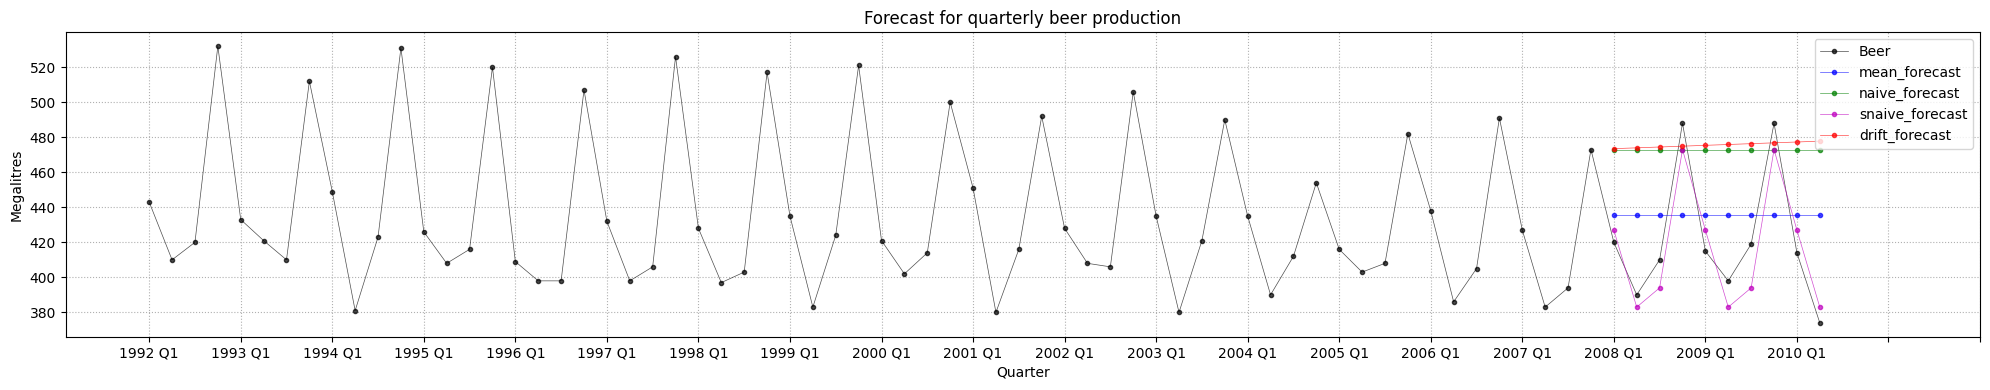

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([recent_production, beer_fc]).set_index("Quarter")
plt.plot(
    plot_df["Beer"],
    "k-",
    plot_df["mean_forecast"],
    "b-",
    plot_df["naive_forecast"],
    "g-",
    plot_df["snaive_forecast"],
    "m-",
    plot_df["drift_forecast"],
    "r-",
    marker='.', lw=0.5, alpha=0.7,
)

# Specify graph features:
ax.set_title("Forecast for quarterly beer production", fontsize=12)
ax.set_ylabel("Megalitres", fontsize=10)
ax.set_xlabel("Quarter", fontsize=10)
x_ticks = np.arange(0, len(plot_df), 4)
ax.set_xticks(x_ticks)

ax.legend(
    ["Beer", "mean_forecast", "naive_forecast", "snaive_forecast", "drift_forecast"],
)

ax.grid(ls='dotted')

plt.tight_layout()

In [26]:
"""accuracy() function: Return a dataframe whith the measures RMSE, MAE, MAPE and MASE of the models evaluated.

* df_forecast: Dataframe with a columns that contain observed values called obs_values and columns that contains forecasts.
* y_train_serie: Numpy array that contain the values used to train the forecast models.
* seasonallity: Factor relative with the seasonallity of the time series forecasted. For non seasonallity time series the factor is 1,
for quarter seasonallity the the factor is 4, for monthly seasonallity the the factor is 12.
"""


def accuracy(df_forecast, y_train_serie, seasonallity):

    method = df_forecast.columns[2:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []

    y = df_forecast.obs_values.values
    # y_hat_naive = df_forecast.naive_forecast.values
    scale = np.abs(y_train_serie[:-seasonallity] - y_train_serie[seasonallity:])
    scale = np.average(scale)

    for i in method:

        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs((y - y_hat) / y)) * 100
        mase = mae_f / scale
        mae_results.append(np.round(mae_f, 2))
        rmse_results.append(np.round(rmse_f, 2))
        mape_results.append(np.round(mape, 2))
        mase_results.append(np.round(mase, 2))

    accuracy_df = pd.DataFrame(
        {
            "method": method,
            "RMSE": rmse_results,
            "MAE": mae_results,
            "MAPE": mape_results,
            "MASE": mase_results,
        }
    )

    return accuracy_df

<Axes: xlabel='metric', ylabel='value'>

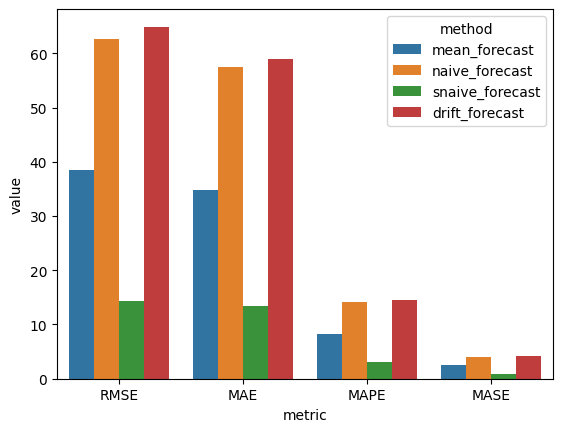

In [40]:
res = accuracy(beer_fc, beer_train["Beer"].values, 4).melt(id_vars=['method'], var_name='metric',)

sns.barplot(
    data=res,
    x='metric',
    y='value',
    hue='method',
)

Figure 21 shows four forecast methods applied to the quarterly Australian beer production using data only to the end of 2007. The actual values for the period 2008–2010 are also shown. We compute the forecast accuracy measures for this period.

The `accuracy()` function will automatically extract the relevant periods from the data (recent_production in this example) to match the forecasts when computing the various accuracy measures.

It is obvious from the graph that the seasonal naïve method is best for these data, although it can still be improved, as we will discover later. Sometimes, different accuracy measures will lead to different results as to which forecast method is best. However, in this case, all of the results point to the seasonal naïve method as the best of these four methods for this data set.

To take a non-seasonal example, consider the Google stock price. The following graph shows the closing stock prices from 2015, along with forecasts for January 2016 obtained from three different methods.

In [41]:
# Create a dataframe from a csv file:
google_stock = pd.read_csv("Assets/GOOGL.csv")

# Filter the year of interest:
google_mask = google_stock["Date"] <= "2015-12-31"
google_2015 = google_stock[google_mask]

# Filter the year of interest:
google_mask = google_stock["Date"] > "2015-12-31"
google_2016 = google_stock[google_mask]

# Create arrays with Close values:
y_google_2015 = google_2015["Close"].values
y_google_2016 = google_2016["Close"].values

In [42]:
# Mean method:
model = HistoricAverage()
model = model.fit(y=y_google_2015)
mean = model.predict(h=len(y_google_2016))

# Naive method:
model = Naive()
model = model.fit(y=y_google_2015)
naive = model.predict(h=len(y_google_2016))

# Drift method:
model = RandomWalkWithDrift()
model = model.fit(y=y_google_2015)
drift = model.predict(h=len(y_google_2016))

print("Mean method:", mean, "\n\nNaive method:", naive, "\n\nDrift method:", drift)

Mean method: {'mean': array([30.99941083, 30.99941083, 30.99941083, 30.99941083, 30.99941083,
       30.99941083, 30.99941083, 30.99941083, 30.99941083, 30.99941083,
       30.99941083, 30.99941083, 30.99941083, 30.99941083, 30.99941083,
       30.99941083, 30.99941083, 30.99941083])} 

Naive method: {'mean': array([38.900501, 38.900501, 38.900501, 38.900501, 38.900501, 38.900501,
       38.900501, 38.900501, 38.900501, 38.900501, 38.900501, 38.900501,
       38.900501, 38.900501, 38.900501, 38.900501, 38.900501, 38.900501])} 

Drift method: {'mean': array([38.94999502, 38.99948905, 39.04898307, 39.0984771 , 39.14797112,
       39.19746514, 39.24695917, 39.29645319, 39.34594722, 39.39544124,
       39.44493526, 39.49442929, 39.54392331, 39.59341733, 39.64291136,
       39.69240538, 39.74189941, 39.79139343])}


In [43]:
# Specify the quarters predicted:
date_pred = google_2016["Date"]

# Create a dataframe with the quarters and values predicted:
Y_pred_df = pd.DataFrame(
    {
        "Date": date_pred,
        "obs_values": y_google_2016,
        "mean_forecast": mean["mean"],
        "naive_forecast": naive["mean"],
        "drift_forecast": drift["mean"],
    }
)

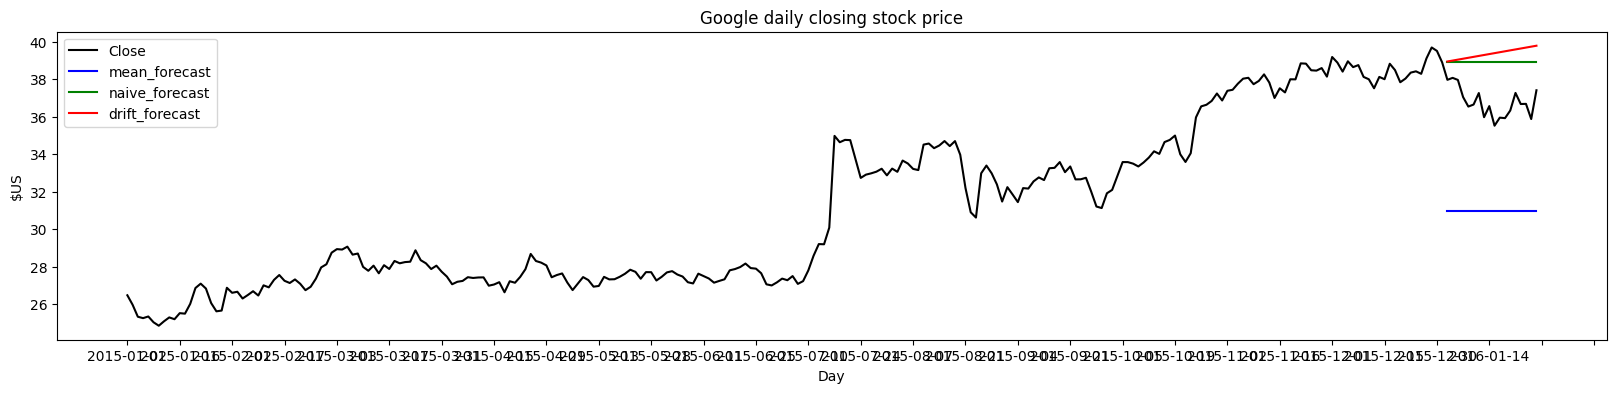

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([google_stock, Y_pred_df]).set_index("Date")
plt.plot(
    plot_df["Close"],
    "k-",
    plot_df["mean_forecast"],
    "b-",
    plot_df["naive_forecast"],
    "g-",
    plot_df["drift_forecast"],
    "r-",
)

# Specify graph features:
ax.set_title("Google daily closing stock price", fontsize=12)
ax.set_ylabel("$US", fontsize=10)
ax.set_xlabel("Day", fontsize=10)
x_ticks = np.arange(0, len(plot_df), 10)
ax.set_xticks(x_ticks)
ax.legend(
    ["Close", "mean_forecast", "naive_forecast", "drift_forecast"],
)

<Axes: xlabel='metric', ylabel='value'>

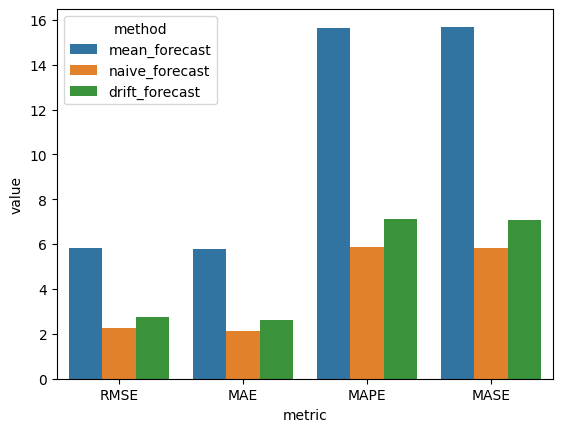

In [45]:
res = accuracy(Y_pred_df, y_google_2015, 1).melt(id_vars=['method'], var_name='metric',)

sns.barplot(
    data=res,
    x='metric',
    y='value',
    hue='method',
)

Here, the best method is the naïve method (regardless of which accuracy measure is used).

## Bibliography

Armstrong, J. S. (1978). Long-range forecasting: From crystal ball to computer. John Wiley & Sons.
Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688.  

***
<span id="fn1">1. That is, a percentage is valid on a ratio scale, but not on an interval scale. Only ratio scale variables have meaningful zeros</span>.